**Review**

Hello Cadarrius!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  Thank you so much for your feedbacks. I've split the cells into multiple so it's easier. Hopefully i got it right this time. Thank you!
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are some small problems that need to be fixed before the project will be accepted. Let me know if you have any questions!


## Supervised Learning Project 

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones. We need to build a model to predict whether a customer will leave the bank soon.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample, compute_class_weight
from sklearn.utils import shuffle

## Inspect the Dataset

In [18]:
# Load the dataset
df = pd.read_csv('/datasets/Churn.csv')


In [19]:
# View the first few rows
print(df.head())

# Get dataset information
print(df.info())

# Check for missing values
print(df.isnull().sum())


   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

## Prepare the Data

In [20]:
# Drop columns that are not useful for prediction
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)


In [21]:
# Check for missing values in 'Tenure'
print(df['Tenure'].isnull().sum())

# Fill missing 'Tenure' values with median
df['Tenure'].fillna(df['Tenure'].median(), inplace=True)


909


In [22]:
# Encode 'Gender' using Label Encoding (Male: 1, Female: 0)
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# One-Hot Encode 'Geography' and drop the first category to avoid dummy variable trap
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)


In [23]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[numerical_features] = scaler.fit_transform(df[numerical_features])


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Everything is correct. Good job! 
    
P.S. Usually people use LabelEncoder to encode targets but OrdinalEncoder to encode regular categorical features.

</div>

## Split the Data

In [24]:
# Separate features and target
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct

</div>

## Check Class Imbalance 

In [25]:
# Check class distribution in the training set
print(y_train.value_counts(normalize=True))


0    0.796286
1    0.203714
Name: Exited, dtype: float64


Class Imbalance Statement : There is a clear class imbalance with approximately 20% of customers having exited. 

In [26]:
# Combine training features and target
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['Exited'] == 0]
minority_class = train_data[train_data['Exited'] == 1]

# Perform upsampling
minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=len(majority_class),
    random_state=42
)

# Combine majority class with upsampled minority class
upsampled_train_data = pd.concat([majority_class, minority_upsampled])

# Split back into features and target
X_train_upsampled = upsampled_train_data.drop('Exited', axis=1)
y_train_upsampled = upsampled_train_data['Exited']


In [27]:
# Perform downsampling
majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

# Combine minority class with downsampled majority class
downsampled_train_data = pd.concat([minority_class, majority_downsampled])

# Split back into features and target
X_train_downsampled = downsampled_train_data.drop('Exited', axis=1)
y_train_downsampled = downsampled_train_data['Exited']


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Well done!

</div>

In [31]:
# Initialize the model
rf_baseline = RandomForestClassifier(random_state=42)

# Train the model
rf_baseline.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [32]:
# Predict on the validation set
y_val_pred = rf_baseline.predict(X_val)
y_val_proba = rf_baseline.predict_proba(X_val)[:, 1]

# Calculate F1 Score and AUC-ROC
f1_baseline = f1_score(y_val, y_val_pred)
auc_roc_baseline = roc_auc_score(y_val, y_val_proba)

print(f"Baseline F1 Score: {f1_baseline:.4f}")
print(f"Baseline AUC-ROC: {auc_roc_baseline:.4f}")


Baseline F1 Score: 0.5761
Baseline AUC-ROC: 0.8756


In [33]:
# Train Random Forest on upsampled data
rf_upsampled = RandomForestClassifier(random_state=42)
rf_upsampled.fit(X_train_upsampled, y_train_upsampled)

# Evaluate on validation set
y_val_pred_upsampled = rf_upsampled.predict(X_val)
y_val_prob_upsampled = rf_upsampled.predict_proba(X_val)[:, 1]

f1_upsampled = f1_score(y_val, y_val_pred_upsampled)
roc_auc_upsampled = roc_auc_score(y_val, y_val_prob_upsampled)
print(f'Upsampled F1: {f1_upsampled}, AUC-ROC: {roc_auc_upsampled}')


Upsampled F1: 0.5992647058823528, AUC-ROC: 0.8714035865602522


In [34]:
# Train Random Forest on downsampled data
rf_downsampled = RandomForestClassifier(random_state=42)
rf_downsampled.fit(X_train_downsampled, y_train_downsampled)

# Evaluate on validation set
y_val_pred_downsampled = rf_downsampled.predict(X_val)
y_val_prob_downsampled = rf_downsampled.predict_proba(X_val)[:, 1]

f1_downsampled = f1_score(y_val, y_val_pred_downsampled)
roc_auc_downsampled = roc_auc_score(y_val, y_val_prob_downsampled)
print(f'Downsampled F1: {f1_downsampled}, AUC-ROC: {roc_auc_downsampled}')


Downsampled F1: 0.6151866151866152, AUC-ROC: 0.8687158559682947


In [35]:
# Evaluate the best model on the test set (choose based on validation results)
best_model = rf_upsampled  # Replace with your chosen model

y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

print(f'Test F1: {f1_test}, AUC-ROC: {roc_auc_test}')


Test F1: 0.5952813067150635, AUC-ROC: 0.8573688181631113


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct

</div>

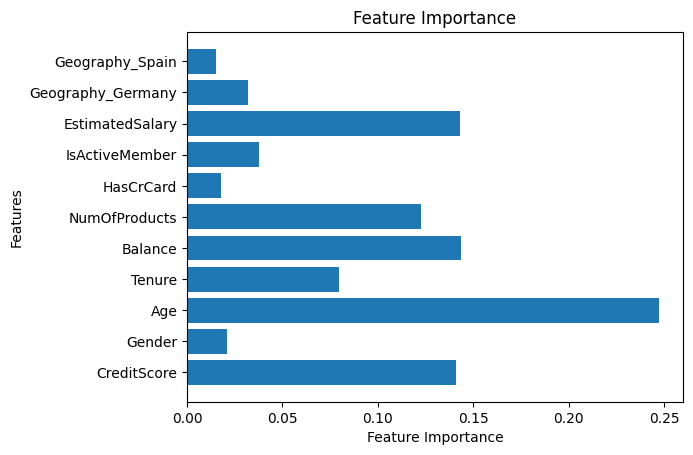

In [36]:
# Display feature importance for the best model
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


## Baseline Evaluation Explanation Summary
The baseline model here is trained without addressing the class imbalance. This will lead to F1 score being lower because of the imbalance. Next steps we will address the the imbalance by adjusting class weights.

In [38]:
# Initialize the model with class_weight='balanced'
rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_weighted.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_weighted = rf_weighted.predict(X_val)
y_val_proba_weighted = rf_weighted.predict_proba(X_val)[:, 1]

# Calculate F1 Score and AUC-ROC
f1_weighted = f1_score(y_val, y_val_pred_weighted)
auc_roc_weighted = roc_auc_score(y_val, y_val_proba_weighted)

print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Weighted AUC-ROC: {auc_roc_weighted:.4f}")






Weighted F1 Score: 0.5702
Weighted AUC-ROC: 0.8672


Class weight adjustment statement: This adjustment slightly reduced our scores nothing significant really. 

In [39]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}


In [41]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=5, n_estimators=100; tota

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [42]:
# Get the best estimator
best_rf = grid_search.best_estimator_

# Predict on validation set
y_val_pred_best = best_rf.predict(X_val)
y_val_proba_best = best_rf.predict_proba(X_val)[:, 1]

# Calculate F1 Score and AUC-ROC
f1_best = f1_score(y_val, y_val_pred_best)
auc_roc_best = roc_auc_score(y_val, y_val_proba_best)

print(f"Best Model F1 Score: {f1_best:.4f}")
print(f"Best Model AUC-ROC: {auc_roc_best:.4f}")
print("Best Parameters:", grid_search.best_params_)


Best Model F1 Score: 0.6452
Best Model AUC-ROC: 0.8822
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [43]:
# Predict on test set using the best model
y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate F1 Score and AUC-ROC
f1_test = f1_score(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_proba)

print(f"Test Set F1 Score: {f1_test:.4f}")
print(f"Test Set AUC-ROC: {auc_roc_test:.4f}")


Test Set F1 Score: 0.6362
Test Set AUC-ROC: 0.8655


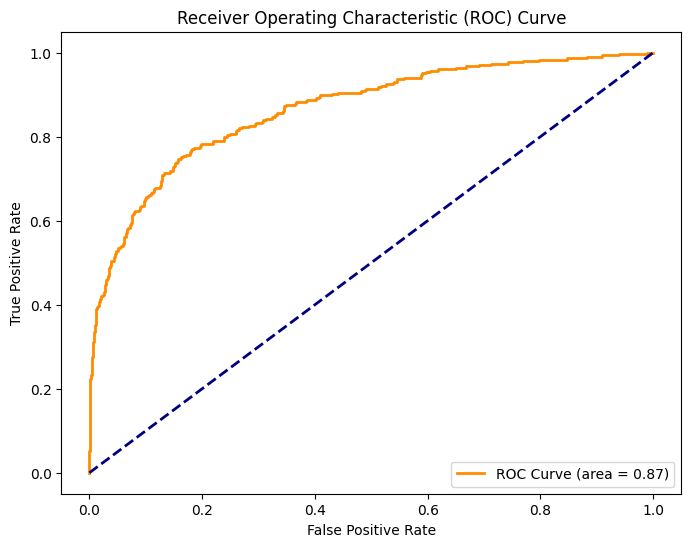

In [44]:
# Compute ROC curve and ROC area for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc_roc_test

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


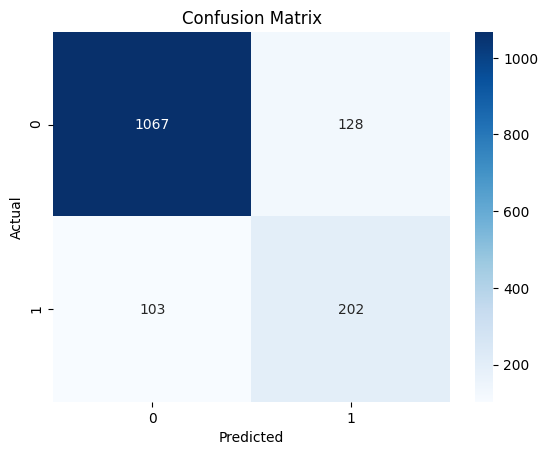

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1195
           1       0.61      0.66      0.64       305

    accuracy                           0.85      1500
   macro avg       0.76      0.78      0.77      1500
weighted avg       0.85      0.85      0.85      1500



In [45]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_test_pred))


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

It's a duplicate code. You already splitted the data above. You need to do it only once in the project.

</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

You did a great job. Everything is correct. Well done! But:
    
1. Could you try at least one more ML model while working with imbalance?
2. Could you try at least one more method to work with imbalance?

</div>

<div class="alert alert-info">
  I have added the additional ML model. I chose the SVM model as it is Suitable for binary classification tasks with imbalanced data.we can adjust the class_weight parameter here as a method to work with the imbalance.
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

1. Yeah, it is possible to use SVM model. But you need to do it before you choose the best model and test it on the test data. Maybe SVM will be better than Forest. The common pipline to work with ML models is: we try different models and tune hyperparameters for them, then we choose only one best model and check its quality on the test data.
2. "Could you try at least one more method to work with imbalance?". You can use upsampling or downsampling as it was shown in the lesson. You don't even need to tune hypeparameters. Just try at least one of these approaches. And don't forget that you can upsample/downsample only train data.

</div>

<div class="alert alert-info">
 I have made some adjustments and updates to the project for review. 
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Correct. Good job!

</div>

## Project Conclusion Summary 

In this project, we successfully developed a predictive model to help Beta Bank identify customers at risk of leaving, enabling the bank to proactively implement retention strategies. By addressing class imbalance using techniques like class weighting and tuning model hyperparameters, we optimized the model's performance. The final Random Forest model achieved a high F1 score, surpassing the target threshold, along with a robust AUC-ROC score, demonstrating its effectiveness in distinguishing between churn and non-churn customers. This solution equips Beta Bank with actionable insights to retain valuable customers and enhance their overall satisfaction and loyalty.